In [1]:
# for analysis
import pandas as pd
import datetime as dt
import scipy as sp
import scipy.stats as stats

# for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
matplotlib.rc('font', **font)

# for retreiving data
import sqlite3
from src import clean_data as d
conn = sqlite3.connect('data/billboard-200.db')

In [2]:
# use src/clean_data.py to compile dataframes from raw data
albums_raw, albums, artists, songs = d.get()
song_parameters = d.song_parameters
normal_parameters = d.normal_parameters

In [3]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

def vibe(chart, params = song_parameters):
        return {p:weighted_score(p, chart) for p in params}

# Vibe of Popular Music Over Time

Compile the popularity of each element across every week from 1963-2019

In [4]:
weekly_charts = albums_raw.merge(albums, 
                                 on=['album','artist'], 
                                 how='left'
                               ).groupby('date')

week_dates  = [date for date in weekly_charts.groups.keys()]
week_scores = [vibe(chart) for _, chart in weekly_charts]

# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

# Vibe Plots

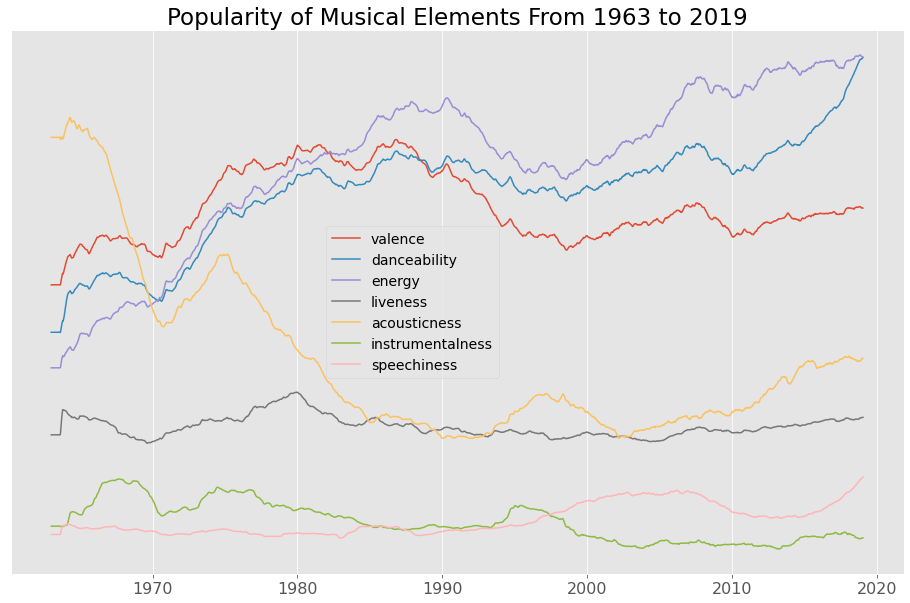

In [5]:
# take a rolling average to smooth out noise
delta = dt.timedelta(weeks=200)
rolling_avg = parameter_ts.rolling(delta).mean()

fig, ax = plt.subplots(figsize=(16,10))
for p in normal_parameters:
    ax.plot(rolling_avg.index, rolling_avg[p])

ax.set_title('Popularity of Musical Elements From 1963 to 2019')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters, fontsize=14, loc='center', bbox_to_anchor=(0.45, 0.5));

# fig.savefig('images/vibe_full_timeseries.png')

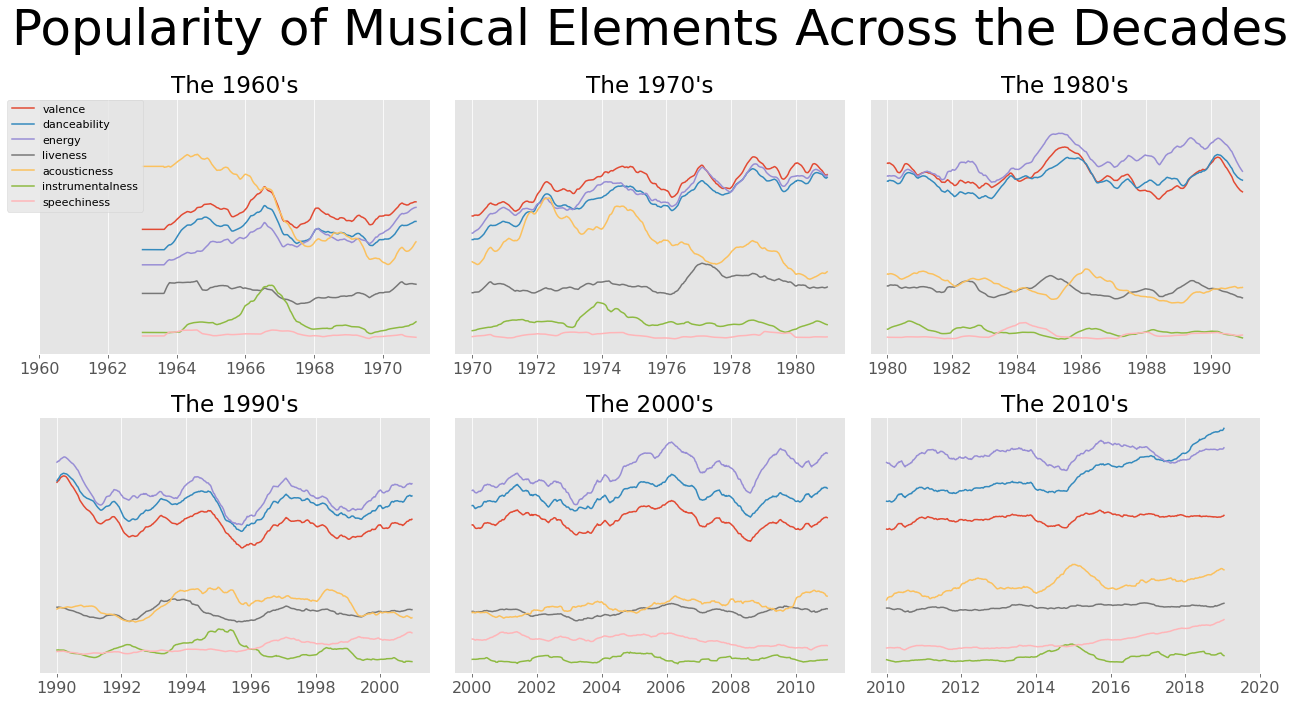

In [6]:
delta = dt.timedelta(weeks=50)
rolling_avg = parameter_ts.rolling(delta).mean()

sixties       = rolling_avg.loc['1960':'1970']
seventies     = rolling_avg.loc['1970':'1980']
eighties      = rolling_avg.loc['1980':'1990']
nineties      = rolling_avg.loc['1990':'2000']
two_thousands = rolling_avg.loc['2000':'2010']
twenty_tens   = rolling_avg.loc['2010':'2020']

decade_ts = [sixties,
            seventies,
            eighties,
            nineties,
            two_thousands,
            twenty_tens]

decade_names = ["1960's",
                "1970's",
                "1980's",
                "1990's",
                "2000's",
                "2010's"]

timestamps = [dt.date(1960, 1, 1),
              dt.date(1970, 1, 1),
              dt.date(1980, 1, 1),
              dt.date(1990, 1, 1),
              dt.date(2000, 1, 1),
              dt.date(2010, 1, 1)]

fig, ax = plt.subplots(2, 3, figsize=(18,10))
for a, name, ts, timestamp in zip(ax.flatten(), decade_names, decade_ts, timestamps):
    for p in normal_parameters:
        a.plot(ts.index, ts[p])

    a.set_title(f'The {name}')
    a.set_ylabel('Popularity')
    a.set_ylim(0, .65)
    a.get_yaxis().set_visible(False)
    
    # 366 days to hack issue with leap years
    years = [timestamp + i*dt.timedelta(days=366) for i in range(0, 11, 2)]
    a.set_xticks(years)
    a.set_xticklabels([year.year for year in years])
    
fig.legend(normal_parameters, fontsize=11, loc='upper left', bbox_to_anchor=(0., 0.858))
fig.suptitle('Popularity of Musical Elements Across the Decades', fontsize=50)
fig.tight_layout();

# fig.savefig('images/vibe_by_decade.png')

# Vibe Hypotheses

To smooth out noise, we'll consider the vibe as a rolling average
of the charts from the last 6 months, the rational being that music
has a lasting effect beyond the week it was in the charts

In [7]:
delta = dt.timedelta(weeks=26)
smooth_ts = parameter_ts.rolling(delta).mean()

## Increase in "Speechiness" after the Rise of Rap and Hip-Hop

Hypothesis: The the average "speechiness" of music trends upward over time after 1985, as rap music was invented and popularized

$$ \frac{\partial (speechiness)}{\partial t} \sim N(\mu_{\partial s}, \sigma) $$

$$ H_0: \ \mu_{\partial s} \leq 0 $$

$$ H_A: \ \mu_{\partial s} > 0 $$

$$ \alpha = .05 $$

In [8]:
ds = smooth_ts['speechiness'].diff().loc['1985':'2020']

T, p_val = stats.ttest_1samp(ds, 0, nan_policy='omit')

# stats.ttest_1samp performs a two sided test
# to convert to one side, divide p_val by two
# and only reject null Hypothesis with T > 0
if p_val/2 < .05 and T > 0:
    print(f'Successfully rejected null hypothesis \n p = {round(p_val, 3)}\n T = {round(T, 1)}')
else:
    print(f'Failed to reject null hypothesis \n p = {round(p_val, 4)}\n T = {round(T, 1)}')

Successfully rejected null hypothesis 
 p = 0.014
 T = 2.5


### Control: Speechiness did not rise in the period before 1985

In [9]:
ds = smooth_ts['speechiness'].diff().loc['1960':'1985']

T, p_val = stats.ttest_1samp(ds, 0, nan_policy='omit')

if p_val/2 < .05 and T > 0:
    print(f'Successfully rejected null hypothesis on \n p = {round(p_val, 3)}\n T = {round(T, 1)}')
else:
    print(f'Failed to reject null hypothesis on \n p = {round(p_val, 4)}\n T = {round(T, 1)}')

Failed to reject null hypothesis on 
 p = 0.7961
 T = -0.3


### Double check: Speechiness still rises over the entire timeseries

In [10]:
ds = smooth_ts['speechiness'].diff()

T, p_val = stats.ttest_1samp(ds, 0, nan_policy='omit')

if p_val/2 < .05 and T > 0:
    print(f'Successfully rejected null hypothesis \n p = {round(p_val, 3)}\n T = {round(T, 1)}')
else:
    print(f'Failed to reject null hypothesis \n p = {round(p_val, 4)}\n T = {round(T, 1)}')

Successfully rejected null hypothesis 
 p = 0.042
 T = 2.0


## Decreasing Popularity of Instrumental Music

Hypothesis: The the average "instrumentalness" of music trends downward over time

$$ \frac{\partial (instrumentalness)}{\partial t} \sim N(\mu_{\partial i}, \sigma) $$

$$ H_0: \ \mu_{\partial i} \geq 0 $$

$$ H_A: \ \mu_{\partial i} < 0 $$

$$ \alpha = .05 $$

In [11]:
di = smooth_ts['instrumentalness'].diff()

T, p_val = stats.ttest_1samp(di, 0, nan_policy='omit')

# stats.ttest_1samp performs a two sided test
# to convert to one side, divide p_val by two
# and only reject null Hypothesis with T < 0
if p_val/2 < .05 and T < 0:
    print(f'Successfully rejected null hypothesis \n p = {round(p_val, 3)}\n T = {round(T, 1)}')
else:
    print(f'Failed to reject null hypothesis \n p = {round(p_val, 4)}\n T = {round(T, 1)}')

Failed to reject null hypothesis 
 p = 0.8272
 T = -0.2


## Relationship Between Valence, Danceability, and Energy
Hypothesis: The relationship between danceability and energy is consistent over time, but both of thier relationships with valence (measure of positiveness) have drifted apart

$$ valence - danceability = X $$

$$ danceability - energy = Y $$

$$ energy - valence = Z $$


$$ \frac{\partial X}{\partial t} \sim N(\mu_{\partial x}, \sigma) $$

$$ \frac{\partial Y}{\partial t} \sim N(\mu_{\partial y}, \sigma) $$

$$ \frac{\partial Z}{\partial t} \sim N(\mu_{\partial z}, \sigma) $$


$$ H_0: \mu_{\partial x} = \mu_{\partial y} = \mu_{\partial z} = 0 $$

$$ \alpha = .05 $$

**Assumption:** ∂x, ∂y, ∂z, are normally distributed

In [12]:
dx = (smooth_ts['valence'] - smooth_ts['danceability']).diff()
dy = (smooth_ts['danceability'] - smooth_ts['energy']).diff()
dz = (smooth_ts['energy'] - smooth_ts['valence']).diff()

_, px = stats.ttest_1samp(dx, 0, nan_policy='omit')
_, py = stats.ttest_1samp(dy, 0, nan_policy='omit')
_, pz = stats.ttest_1samp(dz, 0, nan_policy='omit')

if px < .05:
    print(f'Successfully rejected null hypothesis on \n [valence vs danceability] : p = {round(px, 4)}\n')
else:
    print(f'Failed to reject null hypothesis on \n [valence vs danceability] : p = {round(px, 4)}\n')

if py < .05:
    print(f'Successfully rejected null hypothesis on \n [danceability vs energy] : p = {round(py, 4)}\n')
else:
    print(f'Failed to reject null hypothesis on \n [danceability vs energy] : p = {round(py, 4)}\n')

if pz < .05:
    print(f'Successfully rejected null hypothesis on \n [energy vs valence] : p = {round(pz, 4)}\n')
else:
    print(f'Failed to reject null hypothesis on \n [energy vs valence] : p = {round(pz, 4)}\n')

Successfully rejected null hypothesis on 
 [valence vs danceability] : p = 0.0

Failed to reject null hypothesis on 
 [danceability vs energy] : p = 0.8525

Successfully rejected null hypothesis on 
 [energy vs valence] : p = 0.0069

